# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### ToDo

1. Разбить площадь на категории и посчитать цену
2. Посчитать цену на кв. метр
3. Валидационная выборка
4. Перенос признаков на тест

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

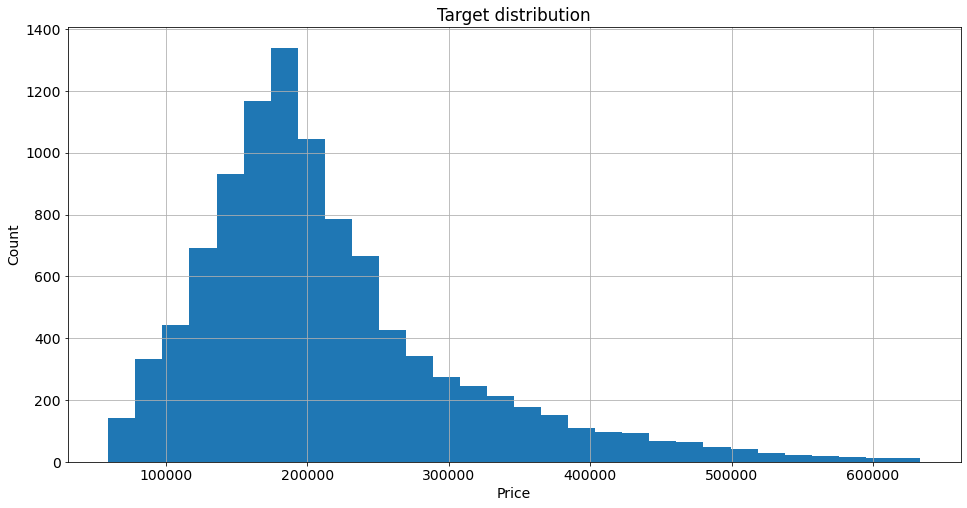

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [13]:
train_df.loc[train_df['DistrictId'] == '1'].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810
47,6186,1,1.0,62.006079,NaN,1.0,7,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,197006.124188
57,16752,1,3.0,79.078673,NaN,1.0,2,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200932.350329
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
87,12537,1,1.0,45.734439,NaN,1.0,21,4.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,179032.666116
140,9529,1,1.0,41.753750,NaN,1.0,15,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,135630.045643
171,10083,1,3.0,85.849340,NaN,1.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,306428.786251


**Номинативные переменные**

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

**Rooms**

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [21]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.975)) |
                    (train_df['Square'] > train_df['Square'].quantile(.025))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [22]:
train_df.shape

(9744, 20)

**HouseFloor, Floor**

In [23]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        38.,  39.,  40.,  44.,  45.,  48.,  99., 117.])

In [24]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [25]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [26]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [27]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
9091        2020
8664        2020
6073        2020
          ...   
2093        1918
1572        1917
7867        1917
485         1917
6250        1914
Name: HouseYear, Length: 9744, dtype: int64

In [28]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = (2005 + 2011) / 2

In [29]:
train_df['HouseYear'].sort_values(ascending=False)

1004    2020
3171    2020
5641    2020
7955    2020
7721    2020
        ... 
9927    1918
7867    1917
485     1917
1572    1917
6250    1914
Name: HouseYear, Length: 9744, dtype: int64

### Обработка пропусков

In [30]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2102
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4673
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [31]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare**

Вычислим среднее отношение жилой площади к разнице между общей площадью и площадью кухни:

In [32]:
square_med_part = ((train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']) /\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']).median()
square_med_part

1.382064744042693

In [33]:
train_df['LifeSquare'].median()

32.52527901166731

Вычислим с помощью получившейся средней доли жилой площади пропущенные значения:

In [34]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
(train_df.loc[train_df['LifeSquare'].isnull(), 'Square']-\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']) /\
square_med_part

In [35]:
train_df['LifeSquare'].median()

33.42511867361472

**Healthcare_1**

In [36]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

#### First_last_floor

In [37]:
train_df['last_floor'] = (train_df['HouseFloor'] == train_df['Floor']).astype(int)

In [38]:
train_df['first_floor'] = (train_df['Floor'] == 1).astype(int)

**Dummies**

In [39]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [40]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,810
1,1,646
2,23,546
3,6,503
4,9,292


In [41]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,11809,27,3.0,115.027311,75.993047,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,0,1,1,1,810
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,1,1,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,1,1,1,646
3,2352,1,1.0,40.409907,27.068129,3.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,0,1,1,1,646
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,B,343995.102962,1,0,1,1,1,88


In [42]:
(train_df['DistrictSize'] > 100).value_counts()

True     4943
False    4801
Name: DistrictSize, dtype: int64

In [43]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [44]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142486.170594
1,0,2.0,176210.812334
2,0,3.0,308098.189977
3,1,1.0,147110.201250
4,1,2.0,202626.530012
...,...,...,...
650,98,4.0,450946.459365
651,99,1.0,158539.052715
652,99,2.0,187254.720362
653,99,3.0,223960.229617


In [45]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,75.993047,10.0,4,10.0,2014,0.075424,...,B,305018.871089,0,0,1,1,1,810,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,177734.553407,0,0,1,1,1,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,282078.720850,0,0,1,1,1,646,1,243966.403596
3,2352,1,1.0,40.409907,27.068129,3.0,10,22.0,1977,0.007122,...,B,168106.007630,0,0,1,1,1,646,1,147110.201250
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,343995.102962,1,0,1,1,1,88,0,201584.441255


#### Для предсказания MedPriceByDistrict для таких районов тестовой выборки, которые не представлены в тренировочных данных, создадим отдельную модель:

In [46]:
train_price_district = train_df[['DistrictId', 'Rooms', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', \
                'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge', 'MedPriceByDistrict' \
                          ]]

In [47]:
train_price_district = train_price_district.groupby(['DistrictId','Rooms'], as_index=False).mean()
train_price_district

,DistrictId,Rooms,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict
0,0,1.0,0.194316,1.0,1.0,27.000000,4967.600000,9.600000,1972.200000,5.400000,7.200000,1.0,0.0,142486.170594
1,0,2.0,0.209080,1.0,1.0,26.764706,4942.705882,10.352941,2076.294118,5.352941,7.294118,1.0,0.0,176210.812334
2,0,3.0,0.250091,1.0,1.0,26.111111,4873.555556,12.444444,2365.444444,5.222222,7.555556,1.0,0.0,308098.189977
3,1,1.0,0.008682,1.0,1.0,2.858824,560.713725,0.027451,852.784314,0.180392,0.988235,1.0,1.0,147110.201250
4,1,2.0,0.009145,1.0,1.0,3.173585,610.747170,0.033962,844.452830,0.211321,1.000000,1.0,1.0,202626.530012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,98,4.0,0.195781,1.0,1.0,23.000000,5212.000000,6.000000,900.000000,3.000000,2.000000,1.0,0.0,450946.459365
651,99,1.0,0.019978,1.0,1.0,46.194444,7508.250000,1.000000,1805.000000,2.361111,5.444444,1.0,0.0,158539.052715
652,99,2.0,0.024206,1.0,1.0,52.390244,8467.000000,1.000000,1653.902439,2.560976,6.243902,1.0,0.0,187254.720362
653,99,3.0,0.017906,1.0,1.0,43.157895,7038.368421,1.000000,1879.052632,2.263158,5.052632,1.0,0.0,223960.229617


In [48]:
X_train_price_district = train_price_district.drop(['MedPriceByDistrict'], axis = 1)

In [49]:
y_train_price_district = train_price_district['MedPriceByDistrict']

In [50]:
X_split_train_price_district, X_split_test_price_district, y_split_train_price_district, y_split_test_price_district = \
train_test_split(X_train_price_district, y_train_price_district, test_size=0.33, shuffle=True, random_state=42)

In [51]:
rf_model_district = RandomForestRegressor(random_state=42, n_estimators=15, max_depth=5, max_features=8)
rf_model_district.fit(X_split_train_price_district, y_split_train_price_district)

RandomForestRegressor(max_depth=5, max_features=8, n_estimators=15,
                      random_state=42)

Train R2:	0.752
Test R2:	0.634


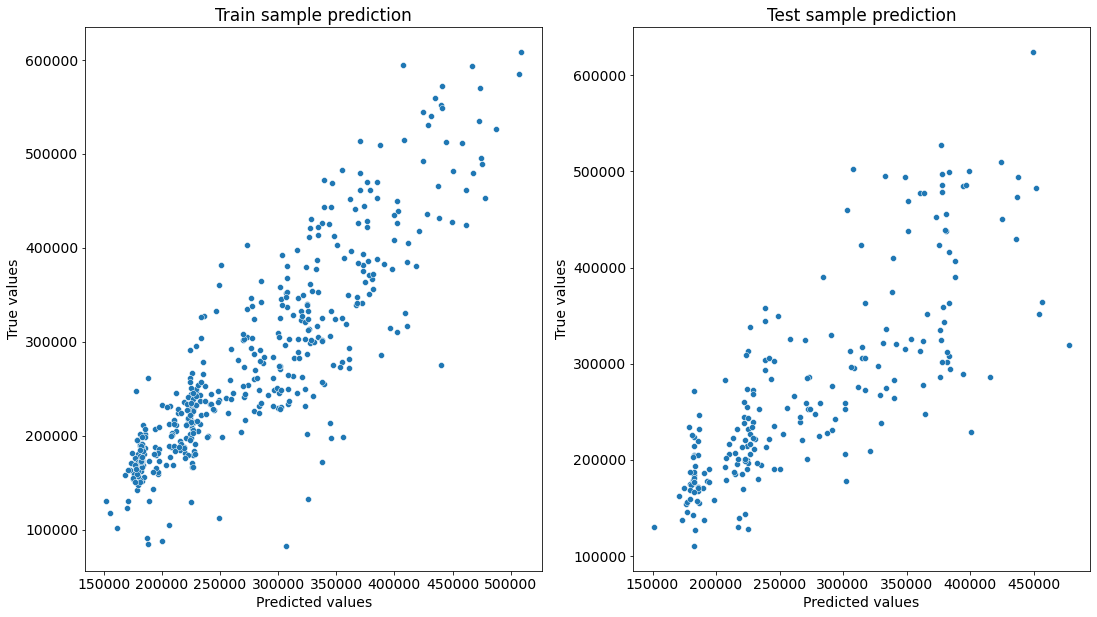

In [52]:
y_train_preds_district = rf_model_district.predict(X_split_train_price_district)
y_test_preds_district = rf_model_district.predict(X_split_test_price_district)

evaluate_preds(y_split_train_price_district, y_train_preds_district, y_split_test_price_district, y_test_preds_district)

### Отбор признаков

In [53]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'last_floor',
 'first_floor',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [54]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict', 'last_floor', 'first_floor']

target_name = 'Price'

### Разбиение на train и test

In [55]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [57]:
rf_model = RandomForestRegressor(random_state=21, n_estimators=1000, max_depth=8, max_features=8)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=8, n_estimators=1000,
                      random_state=21)

**Отложенная выборка**

Train R2:	0.833
Test R2:	0.741


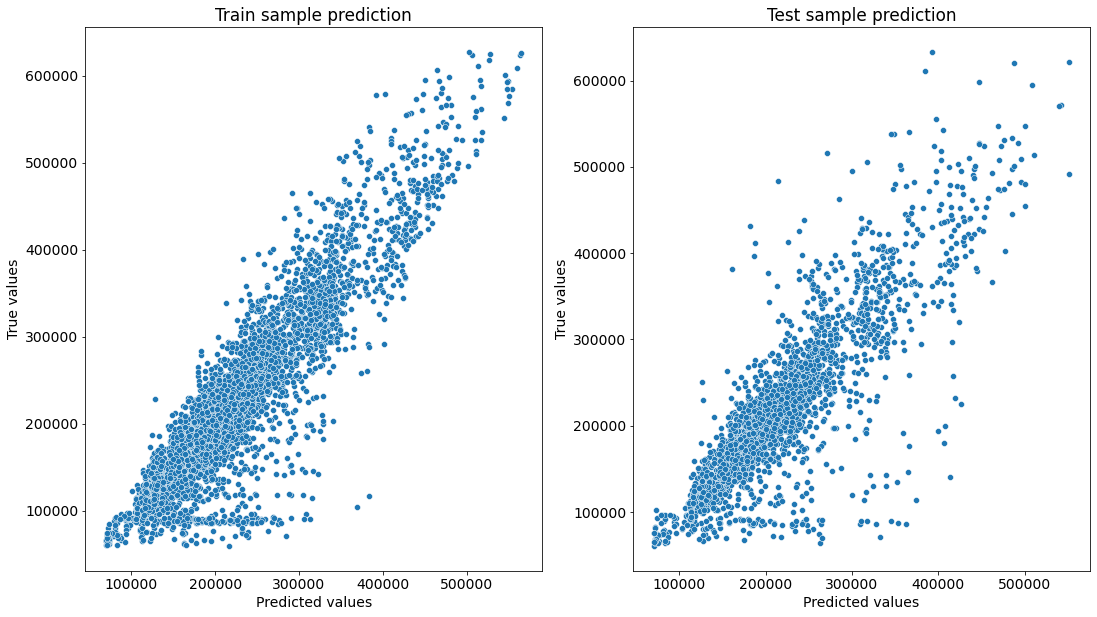

In [58]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [59]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74236153, 0.74368167, 0.75090372])

In [60]:
cv_score.mean()

0.7456489728344543

**Важность признаков**

In [61]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.452892
1,Square,0.182225
0,Rooms,0.085413
2,LifeSquare,0.054770
10,Social_1,0.042977
11,Social_2,0.040113
12,Social_3,0.026658
3,KitchenSquare,0.024500
6,HouseYear,0.017768
17,IsDistrictLarge,0.014953


### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [62]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [63]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [64]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [65]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

In [66]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

In [67]:
test_df[['Square', 'LifeSquare', 'KitchenSquare']].sort_values('KitchenSquare')

,Square,LifeSquare,KitchenSquare
885,73.515949,NaN,0.0
4466,37.100633,NaN,0.0
2308,39.471107,2.206310,0.0
2208,52.103243,NaN,0.0
3294,57.345981,54.716137,0.0
...,...,...,...
1224,66.099096,33.639611,62.0
4127,69.358242,51.247581,65.0
4342,54.629142,31.486308,97.0
4227,112.114019,112.247841,112.0


In [68]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [69]:
test_df.loc[test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.975), 'KitchenSquare'] = \
test_df['KitchenSquare'].median()

In [70]:
test_df[['Square', 'LifeSquare', 'KitchenSquare']].sort_values('KitchenSquare')

,Square,LifeSquare,KitchenSquare
3463,87.916667,NaN,3.0
1073,45.759947,42.012430,3.0
3292,59.458719,NaN,3.0
2208,52.103243,NaN,3.0
3294,57.345981,54.716137,3.0
...,...,...,...
4487,62.445718,32.875830,12.0
960,82.996745,44.258763,12.0
4482,52.855375,32.559571,12.0
4101,67.865454,34.927856,12.0


In [71]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [72]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [73]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [74]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [75]:
floor_outliers

Int64Index([  11,   12,   14,   21,   22,   25,   26,   42,   46,   47,
            ...
            4951, 4952, 4960, 4971, 4973, 4976, 4978, 4980, 4982, 4995],
           dtype='int64', length=792)

In [76]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 38, 46],
      dtype=int64)

#### HouseYear

In [77]:
test_df['HouseYear'].sort_values(ascending=False).unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999,
       1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988,
       1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977,
       1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966,
       1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955,
       1954, 1953, 1952, 1950, 1949, 1948, 1943, 1941, 1940, 1939, 1938,
       1937, 1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1926,
       1920, 1918, 1917, 1914, 1912, 1911, 1910, 1909, 1908], dtype=int64)

In [78]:
test_df.loc[test_df['HouseYear']==6, 'HouseYear'] = test_df['HouseYear'].median()

In [79]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [80]:
square_med_part = ((test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']) /\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare']).median()
square_med_part

1.3784346382245878

In [81]:
test_df['LifeSquare'].median()

32.92508663208161

In [82]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
(test_df.loc[test_df['LifeSquare'].isnull(), 'Square']-\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']) /\
square_med_part

In [83]:
test_df['LifeSquare'].median()

33.9411827312735

In [84]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

### Построение новых признаков

#### First_last_floor

In [85]:
test_df['last_floor'] = (test_df['HouseFloor'] == test_df['Floor']).astype(int)

In [86]:
test_df['first_floor'] = (test_df['Floor'] == 1).astype(int)

**Dummies**

In [87]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [88]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1036.0,1,1,B,0,0,1,1,1,103.0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,900.0,0,0,A,0,0,1,1,0,231.0
2,960,27,2.0,59.463678,36.609410,9.0,19,19.0,1977,0.211401,...,900.0,0,1,B,1,0,1,1,1,810.0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,900.0,0,0,B,1,0,1,1,1,546.0
4,746,74,1.0,53.837056,36.880280,3.0,8,17.0,1977,0.309479,...,990.0,0,6,B,0,0,1,1,1,107.0


**MedPriceByDistrict**

In [89]:
med_price_by_district

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142486.170594
1,0,2.0,176210.812334
2,0,3.0,308098.189977
3,1,1.0,147110.201250
4,1,2.0,202626.530012
...,...,...,...
650,98,4.0,450946.459365
651,99,1.0,158539.052715
652,99,2.0,187254.720362
653,99,3.0,223960.229617


In [90]:
med_price_by_district['DistrictId'].unique()

array(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '11', '110', '111', '112', '113', '114',
       '115', '116', '117', '118', '119', '12', '120', '121', '122',
       '123', '124', '125', '126', '127', '128', '129', '13', '130',
       '131', '132', '133', '134', '135', '136', '137', '138', '139',
       '14', '140', '141', '142', '143', '144', '145', '146', '147',
       '148', '149', '15', '150', '151', '152', '153', '154', '155',
       '156', '157', '158', '159', '16', '160', '161', '162', '163',
       '164', '165', '166', '167', '168', '169', '17', '170', '171',
       '172', '173', '174', '175', '176', '177', '178', '179', '18',
       '180', '181', '182', '183', '184', '185', '186', '187', '188',
       '189', '19', '190', '191', '192', '193', '194', '195', '196', '2',
       '20', '200', '201', '202', '205', '207', '208', '209', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32',
       '33', '34

In [91]:
len(test_df) - test_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
last_floor       0
first_floor      0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
DistrictSize     8
dtype: int64

In [92]:
test_df.loc[test_df['DistrictSize'].isnull(), 'DistrictId'].unique()

array(['210', '203', '204', '198', '211', '206', '212'], dtype=object)

In [93]:
districtsize_is_null = test_df.loc[test_df['DistrictSize'].isnull()].index
districtsize_is_null

Int64Index([1279, 1979, 2280, 2609, 2674, 3723, 4807, 4836], dtype='int64')

In [94]:
test_df.iloc[districtsize_is_null]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
1279,14939,210,2.0,54.953826,31.223917,6.0,3,10.0,1956,8.194346e-02,...,900.0,1,4,B,0,0,1,1,1,NaN
1979,8845,203,2.0,50.417709,27.587971,7.0,1,4.0,1977,1.501689e-02,...,2890.0,0,8,B,0,1,1,1,1,NaN
2280,9155,204,3.0,88.559337,62.854221,8.0,5,7.0,1918,3.731645e-02,...,562.0,4,10,B,0,0,1,1,1,NaN
2609,14024,198,2.0,47.477281,31.069466,5.0,2,5.0,1970,6.076152e-03,...,645.0,6,6,B,0,0,1,1,1,NaN
2674,15655,211,2.0,46.501558,32.276987,5.0,5,5.0,1965,1.800000e-09,...,1815.0,2,5,B,1,0,1,1,1,NaN
3723,13382,206,2.0,46.047289,27.384090,6.0,5,7.0,1930,7.815280e-05,...,1046.0,3,23,B,0,0,1,1,1,NaN
4807,15748,212,2.0,75.655182,36.877626,6.0,2,7.0,1929,0.000000e+00,...,562.0,1,8,B,0,0,1,1,1,NaN
4836,16217,206,4.0,76.428426,50.344903,11.0,1,6.0,1912,4.203159e-02,...,1940.0,2,5,B,0,1,1,1,1,NaN


In [95]:
test_df.iloc[districtsize_is_null]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
1279,14939,210,2.0,54.953826,31.223917,6.0,3,10.0,1956,8.194346e-02,...,900.0,1,4,B,0,0,1,1,1,NaN
1979,8845,203,2.0,50.417709,27.587971,7.0,1,4.0,1977,1.501689e-02,...,2890.0,0,8,B,0,1,1,1,1,NaN
2280,9155,204,3.0,88.559337,62.854221,8.0,5,7.0,1918,3.731645e-02,...,562.0,4,10,B,0,0,1,1,1,NaN
2609,14024,198,2.0,47.477281,31.069466,5.0,2,5.0,1970,6.076152e-03,...,645.0,6,6,B,0,0,1,1,1,NaN
2674,15655,211,2.0,46.501558,32.276987,5.0,5,5.0,1965,1.800000e-09,...,1815.0,2,5,B,1,0,1,1,1,NaN
3723,13382,206,2.0,46.047289,27.384090,6.0,5,7.0,1930,7.815280e-05,...,1046.0,3,23,B,0,0,1,1,1,NaN
4807,15748,212,2.0,75.655182,36.877626,6.0,2,7.0,1929,0.000000e+00,...,562.0,1,8,B,0,0,1,1,1,NaN
4836,16217,206,4.0,76.428426,50.344903,11.0,1,6.0,1912,4.203159e-02,...,1940.0,2,5,B,0,1,1,1,1,NaN


In [96]:
test_df.loc[districtsize_is_null, 'DistrictSize'] = 2

In [97]:
test_df.iloc[districtsize_is_null]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
1279,14939,210,2.0,54.953826,31.223917,6.0,3,10.0,1956,8.194346e-02,...,900.0,1,4,B,0,0,1,1,1,2.0
1979,8845,203,2.0,50.417709,27.587971,7.0,1,4.0,1977,1.501689e-02,...,2890.0,0,8,B,0,1,1,1,1,2.0
2280,9155,204,3.0,88.559337,62.854221,8.0,5,7.0,1918,3.731645e-02,...,562.0,4,10,B,0,0,1,1,1,2.0
2609,14024,198,2.0,47.477281,31.069466,5.0,2,5.0,1970,6.076152e-03,...,645.0,6,6,B,0,0,1,1,1,2.0
2674,15655,211,2.0,46.501558,32.276987,5.0,5,5.0,1965,1.800000e-09,...,1815.0,2,5,B,1,0,1,1,1,2.0
3723,13382,206,2.0,46.047289,27.384090,6.0,5,7.0,1930,7.815280e-05,...,1046.0,3,23,B,0,0,1,1,1,2.0
4807,15748,212,2.0,75.655182,36.877626,6.0,2,7.0,1929,0.000000e+00,...,562.0,1,8,B,0,0,1,1,1,2.0
4836,16217,206,4.0,76.428426,50.344903,11.0,1,6.0,1912,4.203159e-02,...,1940.0,2,5,B,0,1,1,1,1,2.0


In [98]:
test_df.loc[districtsize_is_null, 'DistrictSize'] = 2

In [99]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [100]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,1,B,0,0,1,1,1,103.0,171145.169069
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,A,0,0,1,1,0,231.0,129986.318474
2,960,27,2.0,59.463678,36.609410,9.0,19,19.0,1977,0.211401,...,0,1,B,1,0,1,1,1,810.0,165717.625606
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,B,1,0,1,1,1,546.0,171040.564707
4,746,74,1.0,53.837056,36.880280,3.0,8,17.0,1977,0.309479,...,0,6,B,0,0,1,1,1,107.0,163088.780260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,...,1,2,B,0,0,1,1,1,89.0,185083.534141
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,...,0,7,B,0,0,1,1,1,36.0,425037.641820
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,...,2,5,B,0,0,1,1,1,94.0,151926.384470
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,...,0,11,B,0,0,1,1,1,55.0,168501.260938


#### Не для всех сочетаний DistrictId и Rooms у нас есть значения MedPriceByDistrict:

In [101]:
test_df.loc[test_df['MedPriceByDistrict'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
239,10943,172,3.0,61.194421,48.870517,6.0,1,9.0,1967,0.000000,...,1,5,B,0,1,1,1,1,2.0,NaN
294,2196,52,4.0,104.638510,62.185444,10.0,4,22.0,2005,0.371149,...,2,5,B,0,0,1,1,1,141.0,NaN
369,2144,180,3.0,79.554525,55.080295,7.0,4,4.0,1958,0.037316,...,4,10,B,1,0,1,1,1,3.0,NaN
374,8638,25,5.0,120.330727,115.328430,3.0,14,25.0,2016,0.069753,...,1,11,B,0,0,1,1,1,74.0,NaN
473,11407,79,4.0,37.920348,21.357487,6.0,6,17.0,2014,0.307467,...,2,5,B,0,0,1,0,1,39.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,4273,184,4.0,80.992528,53.191788,7.0,4,4.0,1956,0.246624,...,3,6,B,1,0,1,1,1,5.0,NaN
4807,15748,212,2.0,75.655182,36.877626,6.0,2,7.0,1929,0.000000,...,1,8,B,0,0,1,1,1,2.0,NaN
4836,16217,206,4.0,76.428426,50.344903,11.0,1,6.0,1912,0.042032,...,2,5,B,0,1,1,1,1,2.0,NaN
4910,6445,192,3.0,63.118448,44.978072,8.0,4,8.0,1961,0.225825,...,3,2,B,0,0,0,1,1,5.0,NaN


In [102]:
med_price_by_district_is_null = test_df.loc[test_df['MedPriceByDistrict'].isnull()].index

In [103]:
med_price_by_district_is_null

Int64Index([ 239,  294,  369,  374,  473,  485,  566,  644,  655,  708,  710,
             868,  905,  956, 1137, 1163, 1279, 1340, 1375, 1510, 1538, 1571,
            1702, 1798, 1828, 1929, 1933, 1961, 1979, 2078, 2117, 2212, 2224,
            2243, 2280, 2391, 2447, 2513, 2609, 2659, 2674, 2875, 2885, 2899,
            2922, 3047, 3166, 3207, 3260, 3331, 3456, 3460, 3591, 3651, 3694,
            3723, 3794, 3866, 3884, 3893, 3937, 4002, 4015, 4243, 4446, 4484,
            4626, 4807, 4836, 4910, 4941],
           dtype='int64')

In [104]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,last_floor,first_floor,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,1,B,0,0,1,1,1,103.0,171145.169069
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,A,0,0,1,1,0,231.0,129986.318474
2,960,27,2.0,59.463678,36.609410,9.0,19,19.0,1977,0.211401,...,0,1,B,1,0,1,1,1,810.0,165717.625606
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,B,1,0,1,1,1,546.0,171040.564707
4,746,74,1.0,53.837056,36.880280,3.0,8,17.0,1977,0.309479,...,0,6,B,0,0,1,1,1,107.0,163088.780260


In [105]:
test_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 50).astype(int)

In [106]:
test_df[['DistrictId', 'Rooms','Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',\
         'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge', 'MedPriceByDistrict']].describe()

,Rooms,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,4929.000000
mean,1.90780,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600,0.757000,210358.785237
std,0.81008,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001,0.428938,72353.230188
min,1.00000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,84250.557673
25%,1.00000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,165717.625606
50%,2.00000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,195474.299127
75%,2.00000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,239394.413136
max,6.00000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,593618.746096


In [107]:
med_price_pred = rf_model_district.predict(test_df[['DistrictId', 'Rooms','Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',\
         'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge']])

In [108]:
test_df['MedPricePred'] = med_price_pred

In [109]:
test_df.loc[med_price_by_district_is_null, 'MedPriceByDistrict'] = test_df['MedPricePred']

In [110]:
test_df[['DistrictId', 'Rooms','Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',\
         'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge', 'MedPriceByDistrict', 'MedPricePred']]

,DistrictId,Rooms,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict,MedPricePred
0,44,1.0,0.036122,1,1,24,4378,0,1036.0,1,1,1,1,171145.169069,174766.378756
1,62,1.0,0.072158,1,1,2,629,1,900.0,0,0,0,1,129986.318474,165699.722734
2,27,2.0,0.211401,1,1,9,1892,0,900.0,0,1,1,1,165717.625606,187658.062932
3,23,3.0,0.014073,1,1,2,475,0,900.0,0,0,1,1,171040.564707,267481.792507
4,74,1.0,0.309479,1,1,35,7715,4,990.0,0,6,1,1,163088.780260,172693.729436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,0.069660,1,1,31,6119,4,900.0,1,2,1,1,185083.534141,220770.486548
4996,38,3.0,0.060753,1,1,15,2787,2,520.0,0,7,1,0,425037.641820,343523.992740
4997,101,1.0,0.038693,1,1,28,6533,1,1015.0,2,5,1,1,151926.384470,174766.378756
4998,10,1.0,0.089040,1,1,33,7976,5,900.0,0,11,1,1,168501.260938,174986.417289


In [111]:
test_data = test_df[feature_names + new_feature_names]

In [112]:
result = rf_model.predict(test_data)

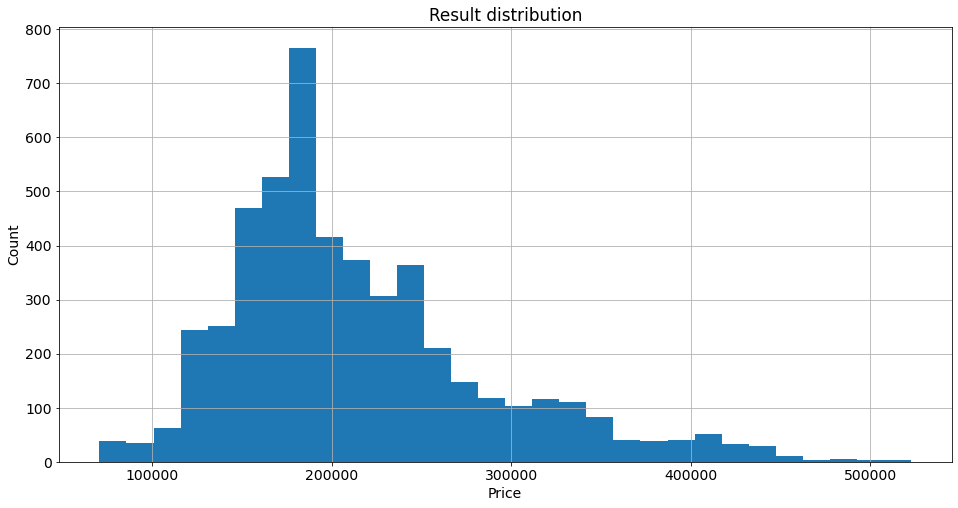

In [113]:
plt.figure(figsize = (16, 8))

pd.Series(result).hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Result distribution')
plt.show()

In [114]:
result

array([160156.12940953, 127621.59913572, 152622.29359629, ...,
       149910.94401202, 175282.62096121, 218469.54515934])

In [115]:
test_df['Price'] = result

In [116]:
test_df[['Id', 'Price']]

,Id,Price
0,4567,160156.129410
1,5925,127621.599136
2,960,152622.293596
3,3848,150112.492259
4,746,172794.001766
...,...,...
4995,10379,181085.833252
4996,16138,399971.855308
4997,3912,149910.944012
4998,5722,175282.620961


In [117]:
test_df.to_csv('DKryukov_predictions.csv', columns=['Id', 'Price'], index=False)